# ✅ BLOQUE 1 — SETUP & EDA

   product_id periodo    tn_total  clientes_positivos cat1         cat2  \
0       20001  201701   934.77222                 186   HC  ROPA LAVADO   
1       20001  201702   798.01620                 185   HC  ROPA LAVADO   
2       20001  201703  1303.35771                 188   HC  ROPA LAVADO   
3       20001  201704  1069.96130                 104   HC  ROPA LAVADO   
4       20001  201705  1502.20132                 238   HC  ROPA LAVADO   

      cat3  brand  sku_size descripcion      fecha  mm-yyyy quarter  \
0  Liquido  ARIEL    3000.0      genoma 2017-01-01  01-2017  2017Q1   
1  Liquido  ARIEL    3000.0      genoma 2017-02-01  02-2017  2017Q1   
2  Liquido  ARIEL    3000.0      genoma 2017-03-01  03-2017  2017Q1   
3  Liquido  ARIEL    3000.0      genoma 2017-04-01  04-2017  2017Q2   
4  Liquido  ARIEL    3000.0      genoma 2017-05-01  05-2017  2017Q2   

   cluster_dtw  
0            1  
1            1  
2            1  
3            1  
4            1  

🎯 Productos objetiv

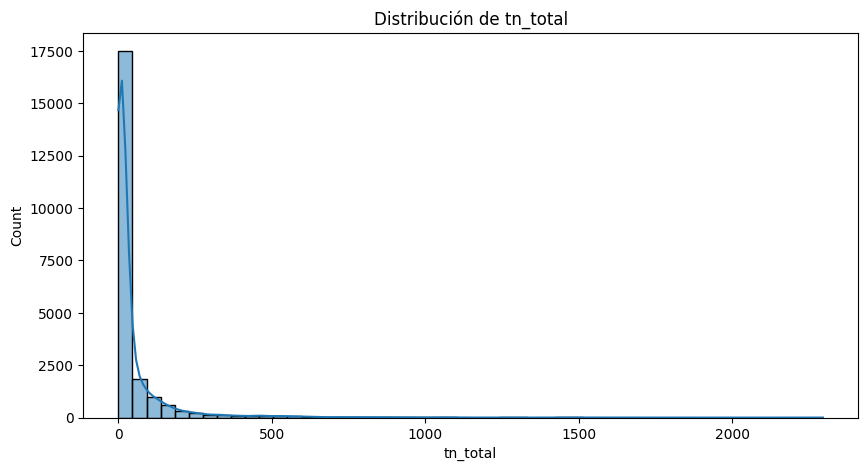

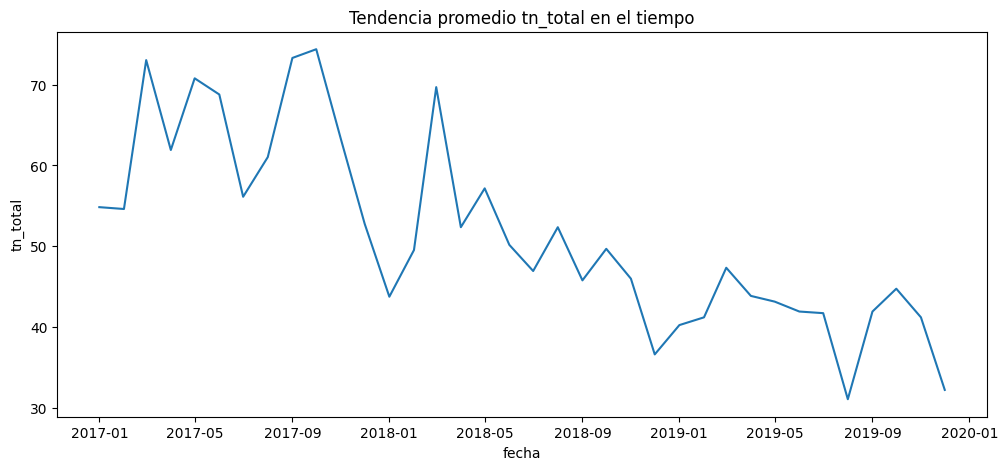


🔍 Nulos por columna:
 product_id            0
periodo               0
tn_total              0
clientes_positivos    0
cat1                  0
cat2                  0
cat3                  0
brand                 0
sku_size              0
descripcion           0
fecha                 0
mm-yyyy               0
quarter               0
cluster_dtw           0
dtype: int64


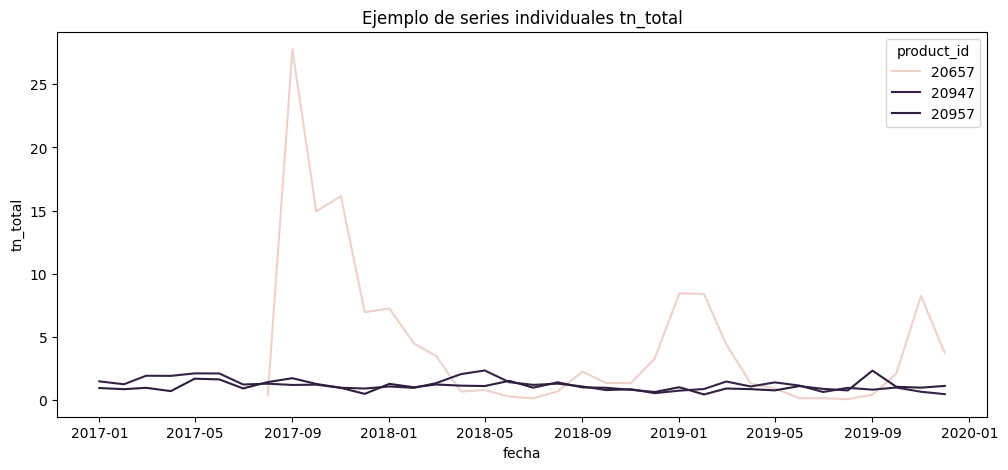

✅ EDA completado: tendencia, outliers y valores nulos detectados.


In [2]:
# ============================================
# 📚 BLOQUE 1 - SETUP & EDA EXPLORATORIO
# ============================================

# 📦 1. Imports básicos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Para modelos y optimización posterior
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import optuna

# 📅
from datetime import datetime

# ============================================
# ⚙️ 2. Cargar parquet y archivo IDs objetivo
# ============================================

PARQUET_PATH = "C:/Developer/Laboratorio_III/data/dataset_product_periodo_con_clusters.parquet"
IDS_PATH = "C:/Developer/Laboratorio_III/data/product_id_apredecir201912.txt"

df = pd.read_parquet(PARQUET_PATH)
df_ids = pd.read_csv(IDS_PATH, sep='\t')
product_ids_objetivo = df_ids['product_id'].unique()

# Filtrar solo productos objetivo
df = df[df['product_id'].isin(product_ids_objetivo)].copy()

# ============================================
# ✅ 3. Normalizar fechas y verificar tipos
# ============================================

df['fecha'] = pd.to_datetime(df['fecha']).dt.normalize()

print(df.head())
print("\n🎯 Productos objetivo:", len(df['product_id'].unique()))

# ============================================
# ✅ 4. EDA Exploratorio
# ============================================

# Distribución general de tn_total
plt.figure(figsize=(10, 5))
sns.histplot(df['tn_total'], bins=50, kde=True)
plt.title("Distribución de tn_total")
plt.show()

# Tendencia temporal promedio
df_grouped = df.groupby('fecha')['tn_total'].mean().reset_index()
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_grouped, x='fecha', y='tn_total')
plt.title("Tendencia promedio tn_total en el tiempo")
plt.show()

# Verificar valores nulos
print("\n🔍 Nulos por columna:\n", df.isnull().sum())

# Check algunos productos ejemplo
sample_pid = np.random.choice(df['product_id'].unique(), 3, replace=False)
df_sample = df[df['product_id'].isin(sample_pid)]
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_sample, x='fecha', y='tn_total', hue='product_id')
plt.title("Ejemplo de series individuales tn_total")
plt.show()

print("✅ EDA completado: tendencia, outliers y valores nulos detectados.")


# ✅ BLOQUE 2: Feature Engineering Avanzado

In [3]:
# ===========================================
# BLOQUE 2: Feature Engineering Avanzado
# ===========================================

# Asegurarse de que 'fecha' esté normalizada
df_fe = df.copy()
df_fe['fecha'] = pd.to_datetime(df_fe['fecha']).dt.normalize()

# ⚙️ Crear la clase: Toneladas del periodo +2
df_fe = df_fe.sort_values(['product_id', 'fecha'])
df_fe['clase'] = df_fe.groupby('product_id')['tn_total'].shift(-2)

# ========================================================
# 1) Lags y Diferencias (1 a 36) + Diferencias con clase
# ========================================================
for lag in range(1, 37):
    df_fe[f'tn_{lag}'] = df_fe.groupby('product_id')['tn_total'].shift(lag)
    df_fe[f'diff_tn_{lag}'] = df_fe['tn_total'] - df_fe[f'tn_{lag}']

# ========================================================
# 2) Medias móviles y diferencia con la clase
# ========================================================
for window in range(1, 37):
    df_fe[f'rollmean_{window}'] = df_fe.groupby('product_id')['tn_total'].transform(
        lambda x: x.shift(1).rolling(window).mean()
    )
    df_fe[f'diff_rollmean_{window}'] = df_fe['tn_total'] - df_fe[f'rollmean_{window}']



# ========================================================
# 3) Contexto temporal enriquecido
# ========================================================
df_fe['year'] = df_fe['fecha'].dt.year
df_fe['month'] = df_fe['fecha'].dt.month
df_fe['quarter'] = df_fe['fecha'].dt.quarter
df_fe['day'] = df_fe['fecha'].dt.day
df_fe['dayofweek'] = df_fe['fecha'].dt.dayofweek

df_fe['month_sin'] = np.sin(2 * np.pi * df_fe['month'] / 12)
df_fe['month_cos'] = np.cos(2 * np.pi * df_fe['month'] / 12)

# ========================================================
# 4) Flags de mínimos y máximos locales
# ========================================================
for window in [3, 6, 12]:
    df_fe[f'is_min_{window}'] = (
        df_fe.groupby('product_id')['tn_total'].transform(
            lambda x: x == x.shift(1).rolling(window).min()
        ).astype(int)
    )
    df_fe[f'is_max_{window}'] = (
        df_fe.groupby('product_id')['tn_total'].transform(
            lambda x: x == x.shift(1).rolling(window).max()
        ).astype(int)
    )

# ========================================================
# 5) Volatilidad e impulso
# ========================================================
df_fe['pct_change_1'] = df_fe.groupby('product_id')['tn_total'].pct_change(1)
df_fe['rolling_std_3'] = df_fe.groupby('product_id')['tn_total'].transform(
    lambda x: x.shift(1).rolling(3).std()
)

# ========================================================
# 6) Variables exógenas (si las tienes)
# ========================================================
# 👉 Ejemplo para unir df_macro que tengas preparado
# df_fe = df_fe.merge(df_macro, on='fecha', how='left')

# ========================================================
# 7) Jerárquicas (promedio de la categoría superior)
# ========================================================
# Si tienes 'brand', 'cat1', 'familia', etc.
if 'brand' in df_fe.columns:
    df_fe['brand_avg'] = df_fe.groupby(['brand', 'fecha'])['tn_total'].transform('mean')
    df_fe['ratio_to_brand_avg'] = df_fe['tn_total'] / (df_fe['brand_avg'] + 1e-6)

if 'cat1' in df_fe.columns:
    df_fe['cat1_avg'] = df_fe.groupby(['cat1', 'fecha'])['tn_total'].transform('mean')
    df_fe['ratio_to_cat1_avg'] = df_fe['tn_total'] / (df_fe['cat1_avg'] + 1e-6)

if 'cat2' in df_fe.columns:
    df_fe['cat2_avg'] = df_fe.groupby(['cat2', 'fecha'])['tn_total'].transform('mean')
    df_fe['ratio_to_cat2_avg'] = df_fe['tn_total'] / (df_fe['cat2_avg'] + 1e-6)

if 'cat3' in df_fe.columns:
    df_fe['cat3_avg'] = df_fe.groupby(['cat3', 'fecha'])['tn_total'].transform('mean')
    df_fe['ratio_to_cat3_avg'] = df_fe['tn_total'] / (df_fe['cat3_avg'] + 1e-6)

# ========================================================
# 8) Cluster DTW como feature + interacción opcional
# ========================================================
df_fe['cluster_dtw_factorized'], _ = pd.factorize(df_fe['cluster_dtw'].fillna(-1))
df_fe['cluster_x_month'] = df_fe['cluster_dtw_factorized'] * df_fe['month']

# ========================================================
# 9) Factorizar otras variables categóricas
# ========================================================
for col in df_fe.select_dtypes(include='object').columns:
    if col not in ['cluster_dtw']:
        df_fe[col + '_factorized'], _ = pd.factorize(df_fe[col])

# ========================================================
# 10) Target Encoding opcional para product_id
# ========================================================
product_mean = df_fe.groupby('product_id')['clase'].transform('mean')
df_fe['product_target_enc'] = product_mean

print("✅ Feature Engineering Avanzado completado")
print(f"Shape final de df_fe: {df_fe.shape}")
print(df_fe.head())


C:\Users\FSONZOGNI\AppData\Local\Temp\ipykernel_15656\1825928374.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fe[f'diff_rollmean_{window}'] = df_fe['tn_total'] - df_fe[f'rollmean_{window}']
C:\Users\FSONZOGNI\AppData\Local\Temp\ipykernel_15656\1825928374.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fe[f'rollmean_{window}'] = df_fe.groupby('product_id')['tn_total'].transform(
C:\Users\FSONZOGNI\AppData\Local\Temp\ipykernel_15656\1825928374.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is u

✅ Feature Engineering Avanzado completado
Shape final de df_fe: (22375, 191)
   product_id periodo    tn_total  clientes_positivos cat1         cat2  \
0       20001  201701   934.77222                 186   HC  ROPA LAVADO   
1       20001  201702   798.01620                 185   HC  ROPA LAVADO   
2       20001  201703  1303.35771                 188   HC  ROPA LAVADO   
3       20001  201704  1069.96130                 104   HC  ROPA LAVADO   
4       20001  201705  1502.20132                 238   HC  ROPA LAVADO   

      cat3  brand  sku_size descripcion  ... cluster_dtw_factorized  \
0  Liquido  ARIEL    3000.0      genoma  ...                      0   
1  Liquido  ARIEL    3000.0      genoma  ...                      0   
2  Liquido  ARIEL    3000.0      genoma  ...                      0   
3  Liquido  ARIEL    3000.0      genoma  ...                      0   
4  Liquido  ARIEL    3000.0      genoma  ...                      0   

  cluster_x_month  periodo_factorized  cat1_f

C:\Users\FSONZOGNI\AppData\Local\Temp\ipykernel_15656\1825928374.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fe[f'is_max_{window}'] = (
C:\Users\FSONZOGNI\AppData\Local\Temp\ipykernel_15656\1825928374.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_fe['pct_change_1'] = df_fe.groupby('product_id')['tn_total'].pct_change(1)
C:\Users\FSONZOGNI\AppData\Local\Temp\ipykernel_15656\1825928374.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

# ✅ BLOQUE 3 — Preparación de datos para modelado

In [4]:
# ===========================================
# BLOQUE 3: Preparación de Datos para Modelado
# ===========================================

# ✅ Confirmar que clase no sea nula en entrenamiento
train_mask = (df_fe['fecha'] <= '2019-10-01') & df_fe['clase'].notnull()
test_mask = df_fe['fecha'] == '2019-12-01'

train_set = df_fe[train_mask].copy()
test_set = df_fe[test_mask].copy()

# ⚙️ Validar
print(f"Train shape: {train_set.shape}")
print(f"Test shape: {test_set.shape}")

# ✅ Reconstruir lista de features dinámicamente
numeric_features = []

# 1) Lags y diferencias
numeric_features += [f'tn_{i}' for i in range(1, 37)]
numeric_features += [f'diff_tn_{i}' for i in range(1, 37)]

# 2) Medias móviles y diferencias
numeric_features += [f'rollmean_{i}' for i in range(1, 37)]
numeric_features += [f'diff_rollmean_{i}' for i in range(1, 37)]

# 3) Flags min/max
numeric_features += [f'is_min_{w}' for w in [3, 6, 12]]
numeric_features += [f'is_max_{w}' for w in [3, 6, 12]]

# 4) Volatilidad / impulso
numeric_features += ['pct_change_1', 'rolling_std_3']

# 5) Contexto temporal
numeric_features += ['year', 'month', 'quarter', 'day', 'dayofweek', 'month_sin', 'month_cos']

# 6) Jerárquicos
for c in ['brand_avg', 'ratio_to_brand_avg', 
          'cat1_avg', 'ratio_to_cat1_avg',
          'cat2_avg', 'ratio_to_cat2_avg',
          'cat3_avg', 'ratio_to_cat3_avg']:
    if c in df_fe.columns:
        numeric_features.append(c)

# 7) Target encoding product_id
numeric_features += ['product_target_enc']

# ✅ Categóricas factorized
factorized_features = ['cluster_dtw_factorized', 'cluster_x_month']
factorized_features += [col for col in df_fe.columns if col.endswith('_factorized') and col not in ['cluster_dtw_factorized']]

# ✅ ID que vamos a usar para merge final
id_features = ['product_id']

# 🔑 Features finales
features = numeric_features + factorized_features + id_features

print(f"Features totales: {len(features)}")
print(features[:10], '...')

# ⚖️ Crear sample weight opcional basado en tn_total
train_set['weight'] = train_set['tn_total'] / train_set['tn_total'].mean()

print("✅ BLOQUE 3: Datos listos para entrenamiento")


Train shape: (20815, 191)
Test shape: (780, 191)
Features totales: 178
['tn_1', 'tn_2', 'tn_3', 'tn_4', 'tn_5', 'tn_6', 'tn_7', 'tn_8', 'tn_9', 'tn_10'] ...
✅ BLOQUE 3: Datos listos para entrenamiento


# ✅ BLOQUE 4-A: AutoML con AutoGluon

In [4]:
# ====================================
# ✅ BLOQUE 4-A — AutoML con AutoGluon
# ====================================

from autogluon.tabular import TabularPredictor

# ⚙️ Features finales
features = numeric_features + factorized_features + ['product_id']

# ⚙️ Sample weight: tonelaje relativo
train_set['weight'] = train_set['tn_total'] / train_set['tn_total'].sum()

# ⚙️ Instanciar Predictor
predictor_ag = TabularPredictor(
    label='clase',
    problem_type='regression',
    eval_metric='mae'
)

# ⚙️ Entrenamiento con ponderación
predictor_ag.fit(
    train_data=train_set[features + ['clase']],
    time_limit=7200,
    presets='best_quality',
    num_bag_folds=5,
    num_stack_levels=1,
    ag_args_fit={'sample_weight': 'weight'},
    num_cpus=2,                # Limita CPUs usados (ajusta según tu PC)
    memory_limit=8*1024**3     # Limita memoria a 8GB (ajusta según tu RAM)
)

# ⚙️ Predicción final
test_set['tn_ag'] = predictor_ag.predict(test_set[features]).clip(lower=0)

# ⚙️ Exportar resultados AutoGluon
test_set[['product_id', 'tn_ag']].to_csv("forecast_AutoML_AutoGluon.csv", index=False)
print(f"✅ [AutoGluon] Predicciones guardadas en forecast_AutoML_AutoGluon.csv")



No path specified. Models will be saved in: "AutogluonModels\ag-20250708_024009"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.9.21
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
CPU Count:          14
Memory Avail:       2.40 GB / 15.31 GB (15.7%)
Disk Space Avail:   199.09 GB / 475.95 GB (41.8%)
Presets specified: ['best_quality']
Enforcing custom memory (soft) limit of 8589934592 GB!
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of Au

(_ray_fit pid=17152) [1000]	valid_set's l1: 11.1269
(_ray_fit pid=17152) [2000]	valid_set's l1: 11.0311 [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=17152) [3000]	valid_set's l1: 11.0132 [repeated 5x across cluster]
(_ray_fit pid=38704) [4000]	valid_set's l1: 10.8769 [repeated 5x across cluster]
(_ray_fit pid=38704) [5000]	valid_set's l1: 10.8807 [repeated 5x across cluster]
(_ray_fit pid=10952) [5000]	valid_set's l1: 9.80737 [repeated 4x across cluster]
(_ray_fit pid=17152) [6000]	valid_set's l1: 11.0045


(_dystack pid=21188) 	-10.3309	 = Validation score   (-mean_absolute_error)
(_dystack pid=21188) 	106.99s	 = Training   runtime
(_dystack pid=21188) 	15.43s	 = Validation runtime
(_dystack pid=21188) Fitting model: LightGBM_BAG_L1 ... Training model for up to 1072.26s of the 1669.15s of remaining time.
(_dystack pid=21188) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.00%)


(_ray_fit pid=24376) [1000]	valid_set's l1: 9.94433
(_ray_fit pid=24376) [2000]	valid_set's l1: 9.87524 [repeated 5x across cluster]
(_ray_fit pid=24376) [3000]	valid_set's l1: 9.86151 [repeated 5x across cluster]
(_ray_fit pid=24376) [4000]	valid_set's l1: 9.85874 [repeated 4x across cluster]
(_ray_fit pid=31456) [5000]	valid_set's l1: 10.8691 [repeated 3x across cluster]


(_dystack pid=21188) 	-10.41	 = Validation score   (-mean_absolute_error)
(_dystack pid=21188) 	105.1s	 = Training   runtime
(_dystack pid=21188) 	8.15s	 = Validation runtime
(_dystack pid=21188) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 962.80s of the 1559.69s of remaining time.
(_dystack pid=21188) 	Warning: Exception caused RandomForestMSE_BAG_L1 to fail during training... Skipping this model.
(_dystack pid=21188) 		Input X contains infinity or a value too large for dtype('float32').
(_dystack pid=21188) Detailed Traceback:
(_dystack pid=21188) Traceback (most recent call last):
(_dystack pid=21188)   File "c:\Users\FSONZOGNI\AppData\Local\anaconda3\envs\labo_III\lib\site-packages\autogluon\tabular\trainer\abstract_trainer.py", line 2169, in _train_and_save
(_dystack pid=21188)     model = self._train_single(**model_fit_kwargs)
(_dystack pid=21188)   File "c:\Users\FSONZOGNI\AppData\Local\anaconda3\envs\labo_III\lib\site-packages\autogluon\tabular\trainer\ab

(_ray_fit pid=36272) [1000]	valid_set's l1: 10.2454
(_ray_fit pid=36116) [1000]	valid_set's l1: 10.0292
(_ray_fit pid=36272) [2000]	valid_set's l1: 10.2271 [repeated 4x across cluster]


(_ray_fit pid=36272) 	Ran out of time, early stopping on iteration 2402. Best iteration is:
(_ray_fit pid=36272) 	[2384]	valid_set's l1: 10.2258
(_dystack pid=21188) 	-10.6299	 = Validation score   (-mean_absolute_error)
(_dystack pid=21188) 	188.67s	 = Training   runtime
(_dystack pid=21188) 	15.66s	 = Validation runtime
(_dystack pid=21188) Fitting model: CatBoost_r177_BAG_L1 ... Training model for up to 488.20s of the 1085.09s of remaining time.
(_ray_fit pid=24256) 	Ran out of time, early stopping on iteration 2392. Best iteration is: [repeated 4x across cluster]
(_ray_fit pid=24256) 	[2388]	valid_set's l1: 11.9245 [repeated 4x across cluster]
(_dystack pid=21188) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.00%)
(_ray_fit pid=27892) 	Ran out of time, early stopping on iteration 1458.
(_dystack pid=21188) 	-10.2446	 = Validation score   (-mean_absolute_error)
(_dystack pid=21188) 	131.99s	 = Training

(_ray_fit pid=2188) [1000]	valid_set's l1: 10.2032 [repeated 5x across cluster]
(_ray_fit pid=2188) [2000]	valid_set's l1: 10.0324 [repeated 5x across cluster]
(_ray_fit pid=2188) [3000]	valid_set's l1: 9.97302 [repeated 5x across cluster]


(_ray_fit pid=2188) 	Ran out of time, early stopping on iteration 3407. Best iteration is:
(_ray_fit pid=2188) 	[3406]	valid_set's l1: 9.95942
(_dystack pid=21188) 	-10.254	 = Validation score   (-mean_absolute_error)
(_dystack pid=21188) 	98.04s	 = Training   runtime
(_dystack pid=21188) 	25.8s	 = Validation runtime
(_dystack pid=21188) Fitting model: NeuralNetFastAI_r191_BAG_L1 ... Training model for up to 240.64s of the 837.52s of remaining time.
(_ray_fit pid=2088) 	Ran out of time, early stopping on iteration 3403. Best iteration is: [repeated 4x across cluster]
(_ray_fit pid=2088) 	[3395]	valid_set's l1: 11.2655 [repeated 4x across cluster]
(_dystack pid=21188) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=21188) 	Warning: Exception caused NeuralNetFastAI_r191_BAG_L1 to fail during training (ImportError)... Skipping this model.
(_dystack pid=21188) 		ray::_ray_fit() (pid=22468, ip

(_ray_fit pid=38148) [1000]	valid_set's l1: 10.8745 [repeated 5x across cluster]
(_ray_fit pid=38148) [2000]	valid_set's l1: 10.598 [repeated 5x across cluster]
(_ray_fit pid=38148) [3000]	valid_set's l1: 10.5011 [repeated 5x across cluster]
(_ray_fit pid=38148) [4000]	valid_set's l1: 10.4373 [repeated 5x across cluster]
(_ray_fit pid=38148) [5000]	valid_set's l1: 10.4063 [repeated 5x across cluster]
(_ray_fit pid=38148) [6000]	valid_set's l1: 10.375 [repeated 5x across cluster]


(_ray_fit pid=38148) 	Ran out of time, early stopping on iteration 6373. Best iteration is:
(_ray_fit pid=38148) 	[6371]	valid_set's l1: 10.3563
(_ray_fit pid=37012) 	Ran out of time, early stopping on iteration 101. [repeated 4x across cluster]
(_dystack pid=21188) 	-10.5562	 = Validation score   (-mean_absolute_error)
(_dystack pid=21188) 	50.02s	 = Training   runtime
(_dystack pid=21188) 	26.46s	 = Validation runtime
(_dystack pid=21188) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 111.69s of the 708.58s of remaining time.
(_ray_fit pid=25072) 	Ran out of time, early stopping on iteration 6413. Best iteration is: [repeated 4x across cluster]
(_ray_fit pid=25072) 	[6411]	valid_set's l1: 11.2976 [repeated 4x across cluster]
(_dystack pid=21188) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=21188) 	Warning: Exception caused NeuralNetTorch_r22_BAG_L1 to fail duri

(_ray_fit pid=7340) [1000]	valid_set's l1: 10.6023 [repeated 5x across cluster]
(_ray_fit pid=7340) [2000]	valid_set's l1: 10.5648 [repeated 5x across cluster]
(_ray_fit pid=7340) [3000]	valid_set's l1: 10.5467 [repeated 4x across cluster]
(_ray_fit pid=38232) [4000]	valid_set's l1: 9.90651 [repeated 3x across cluster]
(_ray_fit pid=38232) [6000]	valid_set's l1: 9.89892 [repeated 2x across cluster]


(_dystack pid=21188) 	-10.5067	 = Validation score   (-mean_absolute_error)
(_dystack pid=21188) 	40.7s	 = Training   runtime
(_dystack pid=21188) 	4.42s	 = Validation runtime
(_dystack pid=21188) Fitting model: NeuralNetTorch_r22_BAG_L2 ... Training model for up to 101.80s of the 101.75s of remaining time.
(_ray_fit pid=17712) 	Ran out of time, early stopping on iteration 79. [repeated 4x across cluster]
(_dystack pid=21188) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.00%)
(_ray_fit pid=4440) c:\Users\FSONZOGNI\AppData\Local\anaconda3\envs\labo_III\lib\site-packages\pandas\core\nanops.py:1248: RuntimeWarning: invalid value encountered in subtract
(_ray_fit pid=4440)   adjusted = values - mean
(_dystack pid=21188) 	Warning: Exception caused NeuralNetTorch_r22_BAG_L2 to fail during training... Skipping this model.
(_dystack pid=21188) 		ray::_ray_fit() (pid=4440, ip=127.0.0.1)
(_dystack pid=21188)   File

✅ [AutoGluon] Predicciones guardadas en forecast_AutoML_AutoGluon.csv


# ✅ BLOQUE 4-B: AutoML con H2O

In [6]:
# ====================================
# ✅ BLOQUE 4-B — AutoML con H2O
# ====================================

import h2o
from h2o.automl import H2OAutoML

# ⚙️ Iniciar H2O
h2o.init(max_mem_size='4G')

# ⚙️ Convertir datasets a H2OFrame
train_h2o = h2o.H2OFrame(train_set[features + ['clase', 'weight']])
test_h2o = h2o.H2OFrame(test_set[features])

# ⚙️ Especificar columna de peso en H2O
aml = H2OAutoML(max_models=10,
                max_runtime_secs=7200,
                sort_metric='MAE',
                seed=42,
                nfolds=5,
                keep_cross_validation_predictions=True)

aml.train(x=features,
          y='clase',
          training_frame=train_h2o,
          weights_column='weight')

# ⚙️ Predicciones finales
preds = aml.predict(test_h2o).as_data_frame()
test_set['tn_h2o'] = preds['predict'].clip(lower=0)

# ⚙️ Exportar resultados H2O
test_set[['product_id', 'tn_h2o']].to_csv("forecast_AutoML_H2O.csv", index=False)
print(f"✅ [H2O] Predicciones guardadas en forecast_AutoML_H2O.csv")

# ⚙️ Importancia de features
lb = aml.leaderboard
print(lb.head(rows=5))

# ⚙️ Cerrar H2O
h2o.shutdown(prompt=False)


Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,5 mins 35 secs
H2O_cluster_timezone:,America/Argentina/Buenos_Aires
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 10 days
H2O_cluster_name:,H2O_from_python_FSONZOGNI_stunl3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.916 Gb
H2O_cluster_total_cores:,14
H2O_cluster_allowed_cores:,14
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
07:54:24.756: AutoML: XGBoost is not available; skipping it.
07:54:24.786: _train param, Dropping bad and constant columns: [rollmean_34, is_max_12, rollmean_35, diff_tn_36, diff_tn_35, diff_tn_34, tn_34, tn_35, diff_rollmean_34, is_max_6, diff_rollmean_35, diff_rollmean_36, rollmean_36, day, tn_36]

██████████████
07:56:02.608: _train param, Dropping bad and constant columns: [rollmean_34, is_max_12, rollmean_35, diff_tn_36, diff_tn_35, diff_tn_34, tn_34, tn_35, diff_rollmean_34, is_max_6, diff_rollmean_35, diff_rollmean_36, rollmean_36, day, tn_36]

█
07:56:37.728: _train param, Dropping bad and constant columns: [rollmean_34, is_max_12, rollmean_35, diff_tn_36, diff_tn_35, diff_tn_34, tn_34, tn_35, diff_rollmean_34, is_max_6, diff_rollmean_35, diff_rollmean_36, rollmean_36, da

H2OJobCancelled: Job<$03017f00000132d4ffffffff$_9e662d866ec269bb2ee37c50b2314f20> was cancelled by the user.

# ✅ BLOQUE 5 — Validación, Ensemble y Export Final

In [ ]:
# ========================================
# ✅ BLOQUE 5 — Validación y Ensamble final
# ========================================

from sklearn.metrics import mean_absolute_error

# ⚙️ Asegurar valores reales para validar en test_set
# Si tienes la 'clase' real para test_set, úsala. Si no, solo compara distribución.
if 'clase' in test_set.columns:
    test_set['tn_real'] = test_set['clase']
else:
    print("⚠️ No hay valores reales de clase en test_set, solo se mostrará promedio.")

# ⚙️ Evaluar MAE individual
if 'tn_real' in test_set.columns:
    mae_ag = mean_absolute_error(test_set['tn_real'], test_set['tn_ag'])
    mae_h2o = mean_absolute_error(test_set['tn_real'], test_set['tn_h2o'])
    print(f"🔍 MAE AutoGluon: {mae_ag:.4f}")
    print(f"🔍 MAE H2O: {mae_h2o:.4f}")
else:
    print("🔍 No hay valor real para calcular MAE exacto.")

# ⚙️ Ensamble simple: promedio ponderado (igual peso)
test_set['tn_ensemble'] = (test_set['tn_ag'] + test_set['tn_h2o']) / 2
test_set['tn_ensemble'] = test_set['tn_ensemble'].clip(lower=0)

# ⚙️ MAE Ensamble
if 'tn_real' in test_set.columns:
    mae_ensemble = mean_absolute_error(test_set['tn_real'], test_set['tn_ensemble'])
    print(f"🔍 MAE Ensemble Promedio: {mae_ensemble:.4f}")

# ⚙️ Exportar resultados finales
output_file = "forecast_AutoML_Ensemble.csv"
test_set[['product_id', 'tn_ensemble']].rename(columns={'tn_ensemble': 'tn'}).to_csv(output_file, index=False)
print(f"✅ Ensamble exportado: {output_file} | Productos: {test_set['product_id'].nunique()}")

# ========================================
# ✅ Feature importance de AutoGluon
# ========================================
try:
    fi_ag = predictor_ag.feature_importance(train_set[features + ['clase']])
    print("📊 Top 10 Importancia AutoGluon:")
    print(fi_ag.head(10))
except Exception as e:
    print(f"⚠️ Error mostrando feature importance AutoGluon: {e}")

# ========================================
# ✅ Feature importance de H2O
# ========================================
try:
    lb = aml.leaderboard
    best_model_id = lb.as_data_frame().iloc[0, 0]
    best_model = h2o.get_model(best_model_id)
    fi_h2o = best_model.varimp(use_pandas=True)
    print("📊 Top 10 Importancia H2O:")
    print(fi_h2o.head(10))
except Exception as e:
    print(f"⚠️ Error mostrando feature importance H2O: {e}")
